In [1]:
from pathlib import Path
from src.model.ITrackerData import TrainITrackerData
from src.model.ITrackerData import TestITrackerData
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from src.model.ITrackerModel import ITrackerModel

In [2]:
dataset_file = Path("../data/raw/gazecapture_subset/eye_tracker_train_and_val.npz")

## Exploration

In [3]:
# Create datasets for training & validation, download if necessary
training_set = TrainITrackerData(str(dataset_file))
validation_set = TestITrackerData(str(dataset_file))

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False)

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Training set has 48000 instances
Validation set has 5000 instances


In [4]:
dataiter = iter(training_loader)
face, eye_left, eye_right, face_mask, y = next(dataiter)


c:\ProgramData\Anaconda3\envs\GazeMouse\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


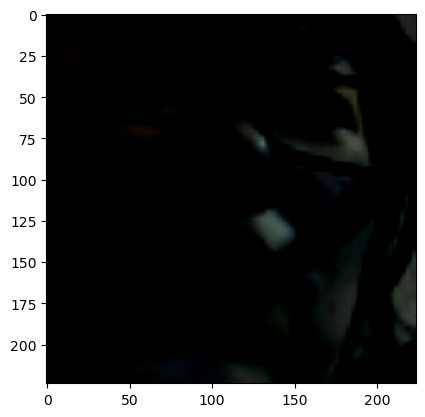

In [9]:
dataiter = iter(training_loader)
face, eye_left, eye_right, face_mask, y = next(dataiter)

# Create a grid from the images and show them
plt.imshow(np.transpose(face.numpy()[0], (1, 2, 0)))

In [10]:
face[0].numpy().shape
eye_left[0].numpy().shape

(3, 224, 224)

## Training

In [8]:
# Hyperparameters
device = torch.device("cuda:0")
num_workers = 0
pin_memory = True

lr = 5e-3
batch_size = 512
print_per_epoch = 10

model = ITrackerModel().to(device)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr)

In [9]:
# Create datasets for training & validation, download if necessary
training_set = TrainITrackerData(str(dataset_file))
validation_set = TestITrackerData(str(dataset_file))

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True, pin_memory=pin_memory, num_workers=num_workers)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=False, pin_memory=pin_memory, num_workers=num_workers)

In [10]:
dataiter = iter(training_loader)
fixeddata = next(dataiter)

c:\ProgramData\Anaconda3\envs\GazeMouse\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [11]:
def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        faces, eyes_left, eyes_right, face_masks, labels = fixeddata
        
        # Send all tensors to device
        faces, eyes_left, eyes_right, face_masks, labels = \
            faces.to(device),\
            eyes_left.to(device),\
            eyes_right.to(device),\
            face_masks.to(device),\
            labels.to(device)
        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(faces, eyes_left, eyes_right, face_masks)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1 == 0:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {}/{} loss: {}'.format(i + 1, len(training_loader), last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            running_loss = 0.

    return last_loss

In [12]:
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    print(f"Epoch: {epoch_number + 1}")
    print(f"Train Loss: {avg_loss}")
    print(f"Val Loss: {avg_vloss}")

    epoch_number += 1

EPOCH 1:
  batch 1/94 loss: 0.03494151306152344
  batch 2/94 loss: 1.221775390625
  batch 3/94 loss: 0.035061855316162106
  batch 4/94 loss: 0.03505247497558594
  batch 5/94 loss: 0.034922508239746096
  batch 6/94 loss: 0.034684066772460935
  batch 7/94 loss: 0.03434649658203125
  batch 8/94 loss: 0.03337674713134765
  batch 9/94 loss: 0.03305068588256836
  batch 10/94 loss: 0.03250863265991211
  batch 11/94 loss: 0.033178859710693356
  batch 12/94 loss: 0.03310842895507812
  batch 13/94 loss: 0.03311391448974609
  batch 14/94 loss: 0.032679737091064455
  batch 15/94 loss: 0.03186103439331055
  batch 16/94 loss: 0.030534976959228514
  batch 17/94 loss: 0.03018305206298828
  batch 18/94 loss: 0.028844680786132813
  batch 19/94 loss: 0.030118385314941407
  batch 20/94 loss: 0.029745517730712892
  batch 21/94 loss: 0.028544832229614257
  batch 22/94 loss: 0.027851617813110352
  batch 23/94 loss: 0.027880390167236327
  batch 24/94 loss: 0.02749283981323242
  batch 25/94 loss: 0.02693637847